# Title

# Introduction

In recent years, the COVID-19 pandemic has forced many educators to adapt their teaching style to an online learning environment. Despite the initial struggles of this transition, many are choosing to remain online even as the pandemic slowly recedes. This decision to remain put does have it's advantages, however many issues with online learning have begun to appear, one of which being the inability to support individual needs of students. A promising solution to this specific problem is user modeling, where a model describing each individual student/user is created. With these user models and information they provide, instructors can tailor their curriculums to best accommodate the needs of their students.

Within each user model, students are primarily grouped by their intuitive knowledge classifier. This classifier attempts to accurately gauge the knowledge classes of students based on five variables: the degree of study time for goal object materials (STG), the degree of repetition number of user for goal object materials (SCG), the degree of study time of user for related objects with goal object (STR), the exam performance of user for related objects with goal object (LPR), and the exam performance of user for goal objects (PEG). Once each of these variables have been taken into account, the knowledge level of each user (UNS) is determined and falls under either very low, low, middle, or high. This generalization helps instructors cater to each individual student without having sort through massive amounts of data.

This brings us to question we are trying answer, which is: which variable(s) most greatly affect the knowledge level of students? In other words, we will attempt to determine how students can optimize their time spent in order to most greatly increase knowledge level.

To answer this question we will be using the User Knowledge Modeling Data Set from the Center for Machine Learning and Intelligent Systems. This data set contains the variables STG, SCG, STR, LPR, PEG, and UNS which were explained in more detail in a previous paragraph. As provided by the Center for Machine Learning and Intelligent Systems, the data set has already been split into training data and testing data, where the training data contains 258 observations and the testing data contains 145 observations. This data set also lacks any NA values; this is verified in the first method.

In [1]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(ggplot2)
library(gridExtra)
library(repr)
install.packages("psych")
library(psych)
library(GGally)
options(repr.plot.width = 15, repr.plot.height = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Methods and results


### Methods description

We will build predictive models through the K-nearest neighbor classification algorithm, and evaluate to find the accuracy-maximizing classifier. Our methods involve:
- Create a recipe to centre and scale data.
- Cross-validate and tune the classifier and  to find appropriate number of neighbors.
- Create a model followed by workflow to fit the training data.
- Filter out accuracies and plot against the number of neighbours.
- Fit the best model to testing data.
- Other than the line plot of accuracies vs. number of neighbours, we can also create scatterplot of predictor variables and color the points by outcome level. We can also have side-by-side bar plots showing actual and predicted number of knowledge levels. 

### Codes used

In [2]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(ggplot2)
library(gridExtra)
library(repr)
install.packages("psych")
library(psych)
library(GGally)
options(repr.plot.width = 15, repr.plot.height = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



**1. Reading Data**

Load data from original source, which is already split into training/testing data. Confirm that the data has no NA values as the training data and testing data both retain the same number of observations even after na.omit function is applied to them. Then show small sections of the data.

In [3]:
train_data <- read_csv("https://raw.githubusercontent.com/fyang1419/group-56-project/main/train_data.csv") |>
select(STG:UNS)

test_data <- read_csv("https://raw.githubusercontent.com/fyang1419/group-56-project/main/test_data.csv") |>
select(STG:UNS)

nrow(train_data)
nrow(na.omit(train_data))

nrow(test_data)
nrow(na.omit(test_data))

New names:
• `` -> `...1`
• `...7` -> `...8`
• `...8` -> `...9`
Rows: 258 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (6): ...1, STG, SCG, STR, LPR, PEG
lgl (2): ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
• `...7` -> `...8`
• `...8` -> `...9`
Rows: 145 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (6): ...1, STG, SCG, STR, LPR, PEG
lgl (2): ...8, ...9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 258

[1] 258

[1] 145

[1] 145

In [4]:
head(train_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


***Table 1.***  *A part of the training data*

In [5]:
head(test_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


***Table 2.***  *A part of the testing data*

**2. Wrangle and clean data**

Since all the predictors are on the same numerical scale of measurements, they are in tidy format. The only adjustment here is change our target variable from character to factor type. 


In [6]:
#tidy data: turn UNS into factors in both sets of data
train_data <- train_data |>
mutate(UNS = factor(UNS, levels=c('very_low','Low','Middle','High')))

test_data <- test_data |>
mutate(UNS = factor(UNS, levels=c('very_low','Low','Middle','High')))

**3. Exploratory data analysis: summary statistics.**

We constructed a summary table for predictors in train-data, as well as a count table for response variable. 

As the summary table shows, the predictors are close in many aspects. All the predictors have the same amount of values (258), same minimum value of 0. Their means range from about 0.36 to about 0.47, their standard deviation ranges from about 0.21 to about 0.26, and their standard error ranges from about 0.013 to about 0.016. Their maximum values ranges from 0.90 to 0.99, which are the same as their ranges. 

The count table for the response variable suggest an unbalanced distribution of levels. The "Middle" level has the maximum count of 88, while the "very_low" level only has 24 points.

In [7]:
summary_pred_train <- describe(train_data[-6], fast=TRUE)
summary_pred_train

,vars,n,mean,sd,min,max,range,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STG,1,258,0.3711473,0.2102712,0,0.99,0.99,0.01309091
SCG,2,258,0.3556744,0.2119623,0,0.90,0.90,0.01319620
STR,3,258,0.4680039,0.2459398,0,0.95,0.95,0.01531154
LPR,4,258,0.4327132,0.2481080,0,0.99,0.99,0.01544653
PEG,5,258,0.4585388,0.2552109,0,0.93,0.93,0.01588874


***Table 3.*** *Summary table of predictors*

In [8]:
UNS_count <- train_data |>
group_by(UNS) |>
    summarise(count = n())
UNS_count

UNS,count
<fct>,<int>
very_low,24
Low,83
Middle,88
High,63


***Table 4.*** *Count table of response variable UNS*

**4. Exploratory data analysis: visualization of training data**

To have an overall image of the continuous predictors, we used "ggpairs" function from the ggplot2 package. Here are our comments on plot matrix below: 
- It has distinct color for each level in all the plots.
- On the diagonal, we have the density plots for each variable on each level. One can see that in general, the predictors show different shapes for different levels, with the exception that STG and SCG both have an overall shape that's skewed to the right. 
- In the last row, the histograms show counts of each level for response variable and predictor variables. It's clear to see that PEG almost has clear cuts from one level to the next, SCG and SCG has more values concentrated in the lower range, STR and LPR have more varied distributions.
- The scatter plots plot each pair of predictors, with points colored by response variable levels. Most scatter plots do not show clear patterns, with the expection of the 4 plots with PEG on the x-axis. In these 4 plots, the 4 levels are in horizontal order. 
- The box plots plot the response variable agains each predictor, showing the distribution of 4 levels in a more straigh forward way. Notably, plots for STG and SCG are similar in the position of boxes, PEG has a clear ladder-like positioning of boxes. 
- The correlation values are between predictors, which we don't really take into consideration. 

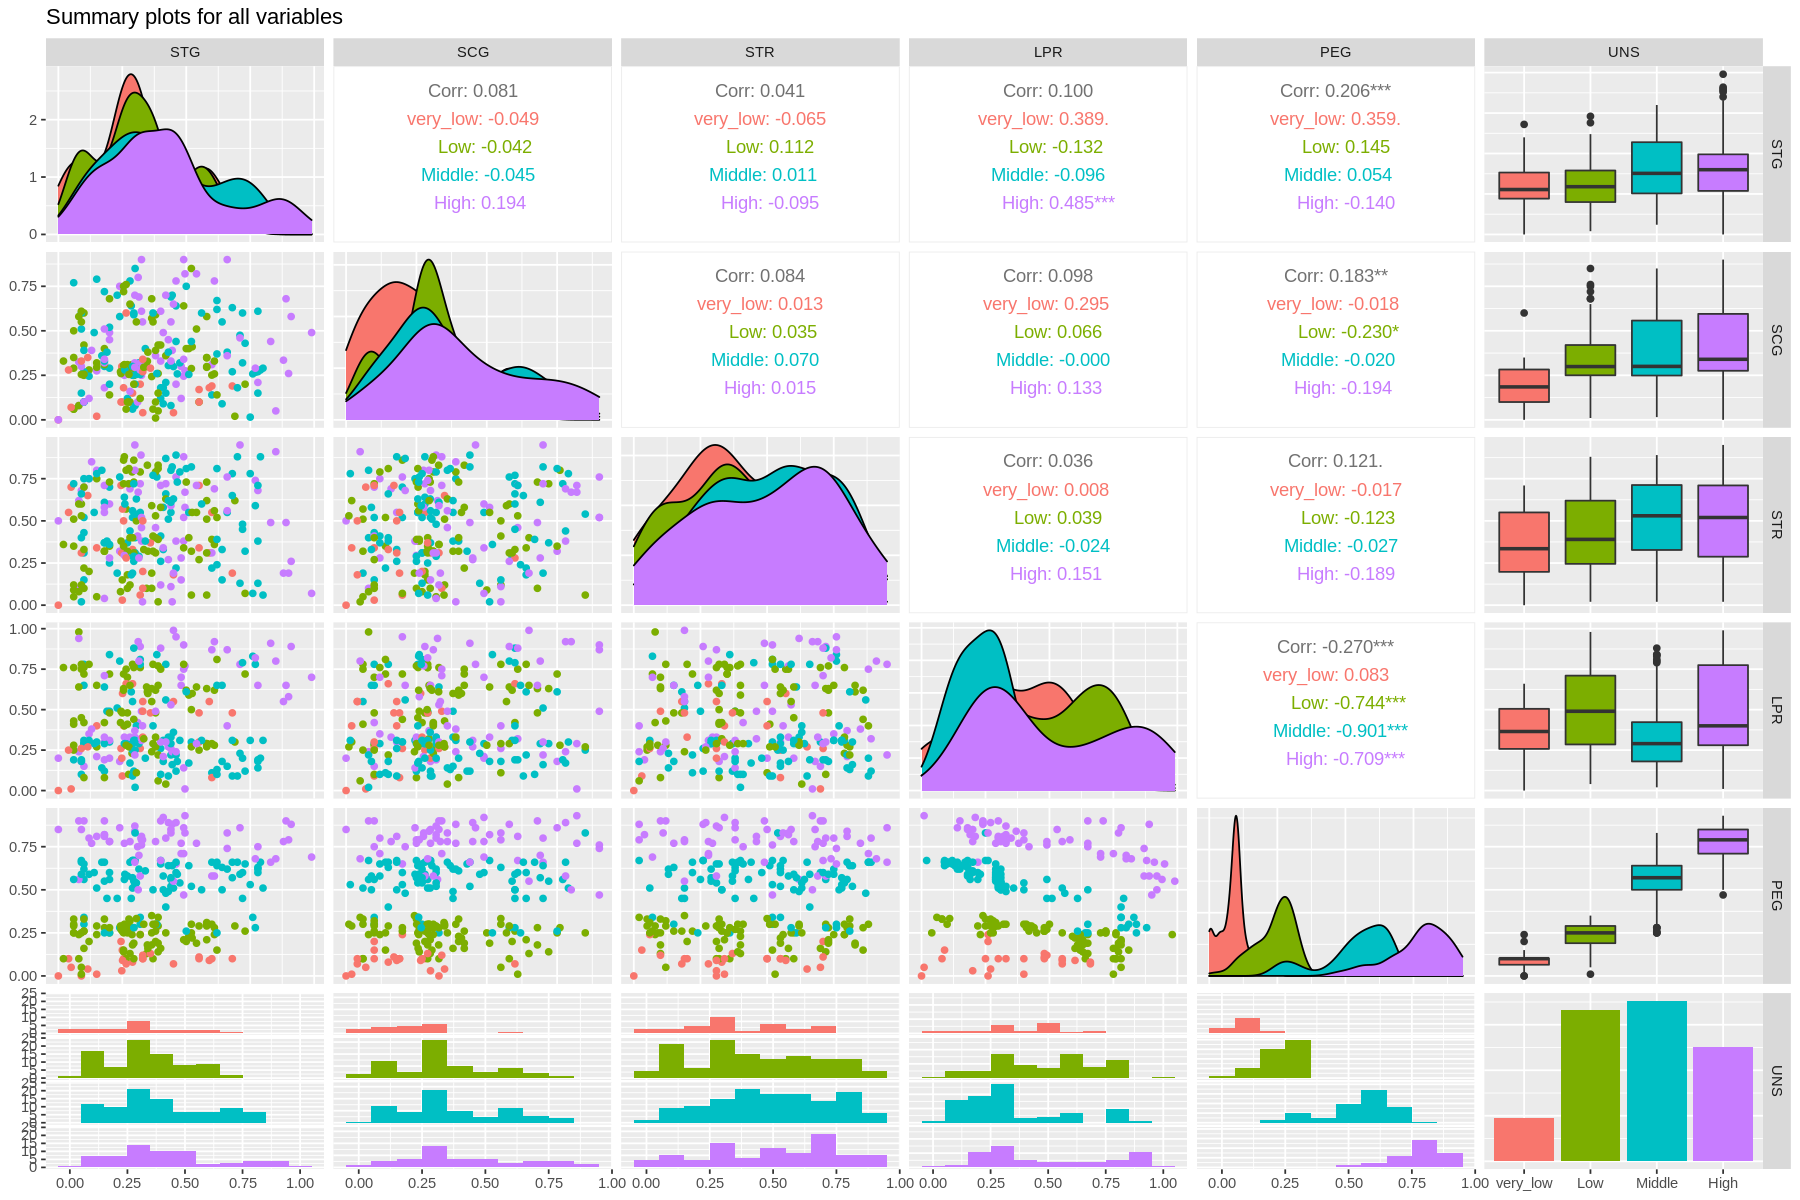

In [22]:
ggpairs(train_data, aes(color=UNS),
       lower = list(combo = wrap("facethist", binwidth = 0.1)),
       title = "Summary plots for all variables") 

***Figure 1.*** *Summary of all variables*

**5. Data analysis**

Before performing the analysis, we first chose 3 predictors based on the summary plots. We already summarized that PEG always shows clear trend, and STG and SCG are similar in some ways. We then focused on the boxplots, because they are the most indicative with easily-comprehensible presentation and rich information. We first picked PEG because its box plot shows an obvious trend as levels rise. Amongst the rest of predictors, we chose STG (between STG and SCG), and STR, because they have relatively consistent and ordered spread of levels. 

Another small decision we had to make was the grid value. Considering the total row number of 258, we decided to try up to 50 neighbours for it should be big enough to contain good k-values before getting to too many overfitting k-values. 

In [10]:
set.seed(1)
vfold <- vfold_cv(train_data, v = 5, strata = UNS)

recipe <- recipe(UNS ~ STG+STR+PEG, data = train_data) |> 
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5)) 

knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = gridvals) |>
  collect_metrics() 
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6748869,5,0.03633795,Preprocessor1_Model01
6,accuracy,multiclass,0.7527149,5,0.04548524,Preprocessor1_Model02
11,accuracy,multiclass,0.7484917,5,0.03331144,Preprocessor1_Model03
16,accuracy,multiclass,0.7446456,5,0.03293269,Preprocessor1_Model04
21,accuracy,multiclass,0.7408748,5,0.04647937,Preprocessor1_Model05
26,accuracy,multiclass,0.7447964,5,0.04299096,Preprocessor1_Model06
31,accuracy,multiclass,0.7292609,5,0.03778875,Preprocessor1_Model07
36,accuracy,multiclass,0.6981146,5,0.02795173,Preprocessor1_Model08
41,accuracy,multiclass,0.6631976,5,0.02984711,Preprocessor1_Model09


***Table 5.*** *Table of neighbors filtered by accuracy*

To visualize the results, we plotted accuracy estimate against the number of neighbors, using line and scatter plots. 

From this plot below, one can see that k-values betwee 6 to 26 have relatively high accuracy estimates. Amongst these values, we decided to pick k=11 because it has almost optimal accuracy estimates, while its neighbouring points also have similar values, and 11 is small enough that computation wouldn't be problematic. We didn't choose k=6, the k-value with optimal estimate, because moving slightly to the left would decrease accuracy estimate drastically. 

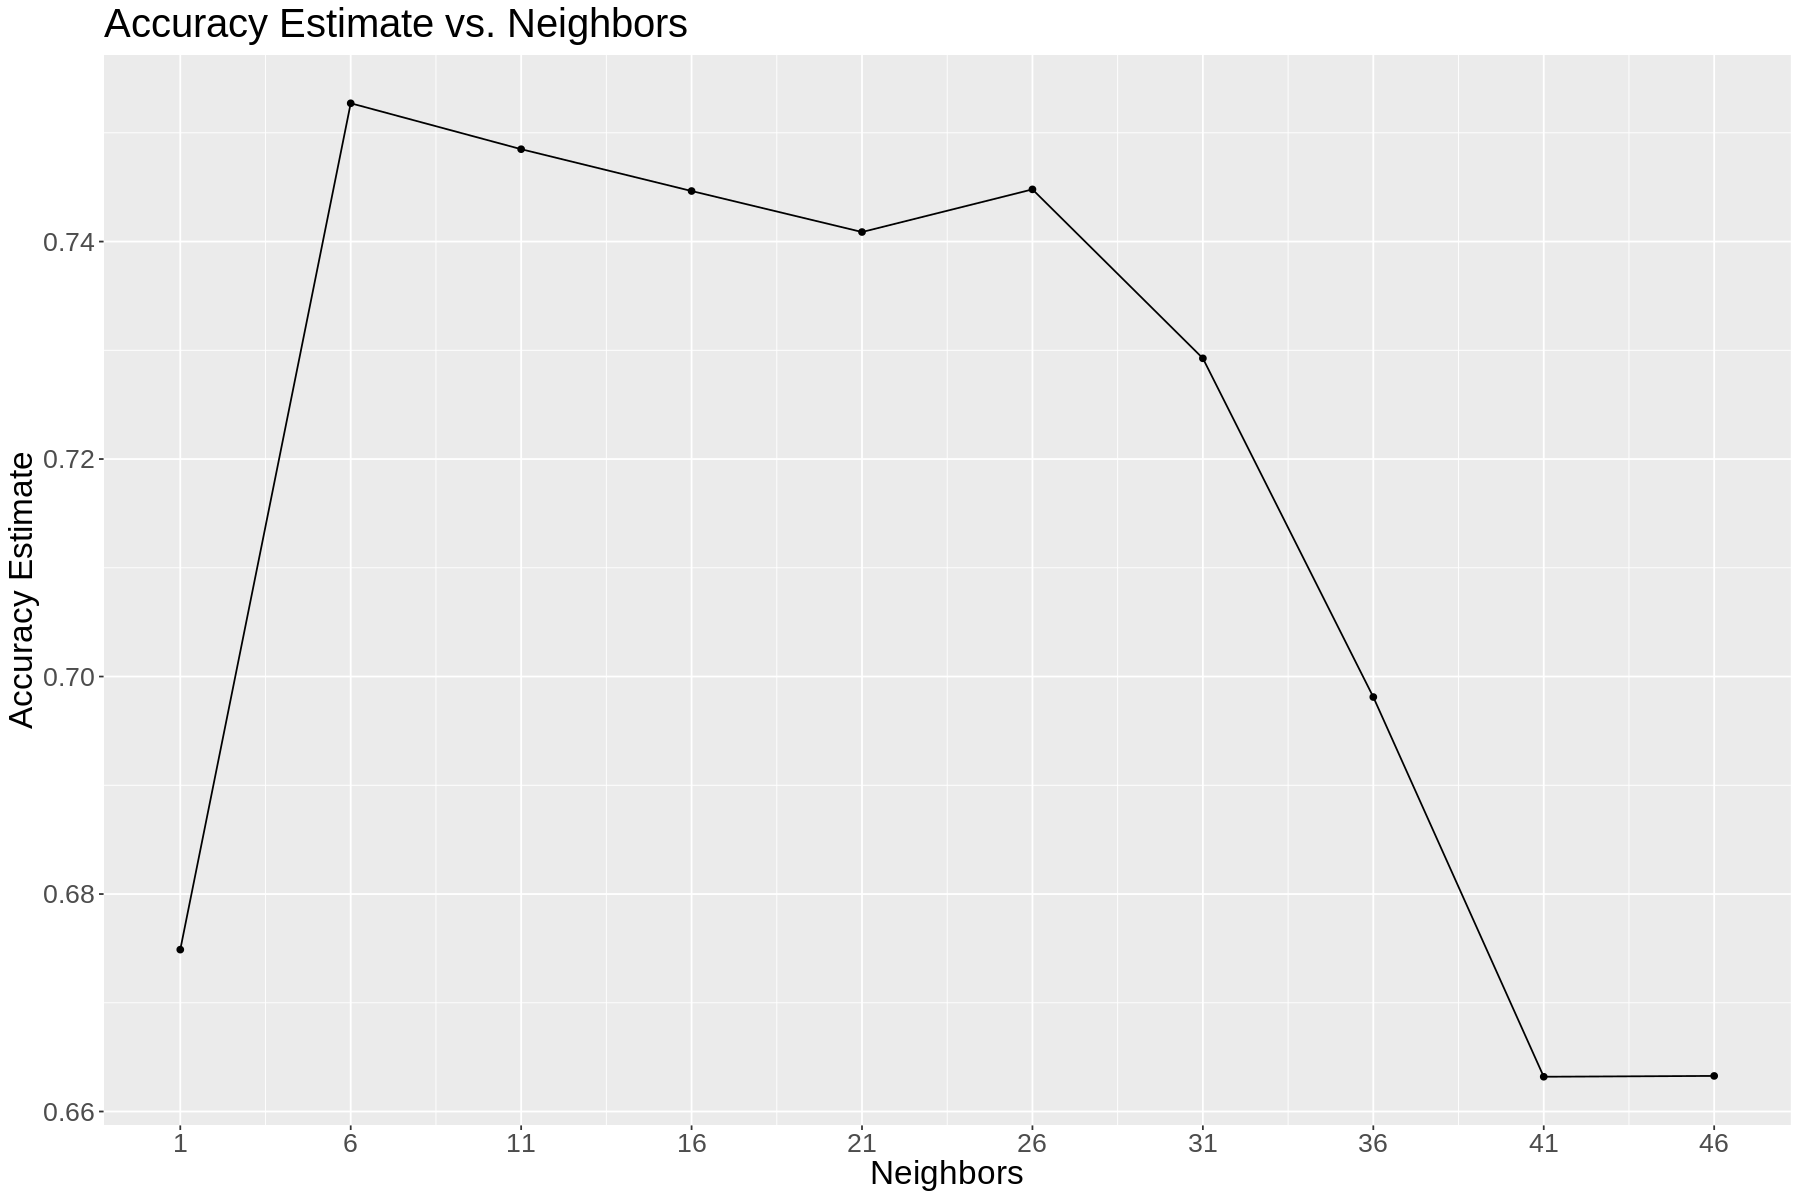

In [11]:
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks=c(1,6,11,16,21,26,31,36,41,46)) +
    ggtitle("Accuracy Estimate vs. Neighbors") +
    theme(text = element_text(size = 20))
cross_val_plot

***Figure 2.*** *Plot of Accuracy Estimate vs Number of Neighbours*

Finally, we construct our best model. 

Eventually, we calculated the accuracy of our model to be about 0.857, a relatively high value. Looking at our confusion matrix, one can also observe that the incorrect predictions are far less than correct ones, which can be a proof that our model is a good fit. 

In [12]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

fit <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_best_spec) |>
  fit(data = train_data) 

predictions <- predict(fit, test_data) |> 
    bind_cols(test_data)

#get accuracy
acc <- predictions |> 
    metrics(truth = UNS, estimate = .pred_class) |>  
    select(.metric, .estimate) |> 
    head(1)
acc


.metric,.estimate
<chr>,<dbl>
accuracy,0.8571429


***Table 6.*** *Table showing model accuracy*

In [13]:
#confusion matrix
cm <-predictions |> 
    conf_mat(truth = UNS, estimate = .pred_class) #confusion matrix
cm

          Truth
Prediction very_low Low Middle High
  very_low        0   1      0    0
  Low             0  44      9    0
  Middle          0   1     23    4
  High            0   0      2   35

***Table 6.*** *Confusion Matrix of predictions*

**6. Analysis visualization**

On top of our confusion matrix, we made scatter plots between each 2 predictors, and colored by predicted levels. It would be difficult to make visualization in 3 dimension, because we wouldn't be able to observe all the points easily. 

We immediately recognize a pattern same as in the training data: when plot any predictor against PEG, there is very clear division of levels among the points. This should be due to PEG being very 

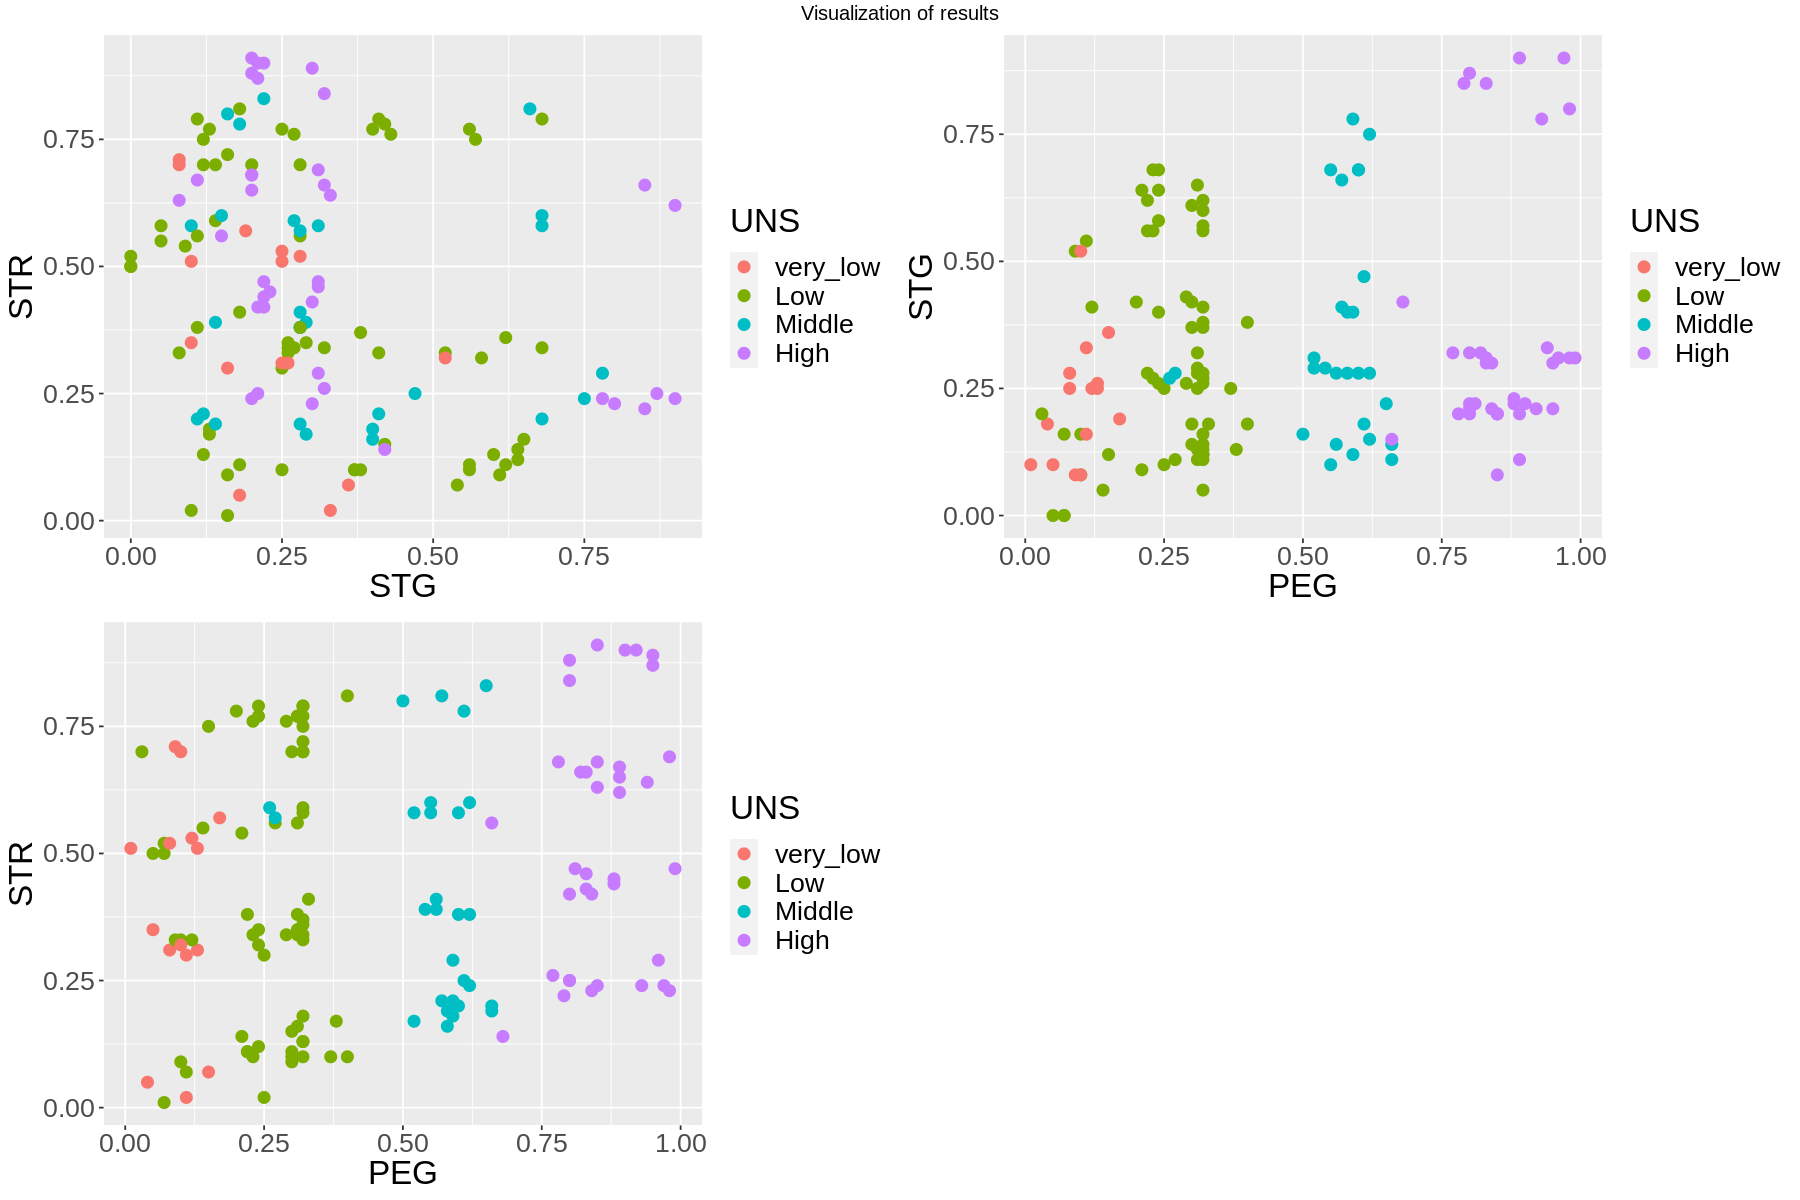

In [23]:
STG_STR <- ggplot(predictions, aes(x=STG, y=STR, color=.pred_class)) +
geom_point() +
labs(x="STG", y="STR", color="UNS") +
geom_point(size = 3) +
theme(text=element_text(size=20))

STG_PEG <- ggplot(predictions, aes(x=PEG, y=STG, color=.pred_class)) +
geom_point() +
labs(x="PEG", y="STG", color="UNS") +
geom_point(size = 3) +
theme(text=element_text(size=20))

PEG_STR <- ggplot(predictions, aes(x=PEG, y=STR, color=.pred_class)) +
geom_point() +
labs(x="PEG", y="STR", color="UNS") +
 geom_point(size = 3) +
theme(text=element_text(size=20))

grid.arrange(STG_STR, STG_PEG, PEG_STR, nrow=2, top="Visualization of results")

***Figure 3.*** *Scatter plots using two predictors at a time*

## Discussion
The predictory variables chosen are the degree of study time for goal object materials (STG), the degree of study time of user for related objects with goal object (STR), and the exam performance of user for goal objects (PEG). From the scatterplots above, STR and STG scatterplot do not contribute much towards the knowledge level (UNS). PEG and STG show some contribution with PEG seeming to be most important. The same can be said for PEG and STR which shows a better distribtuion. We see that as STG (against PEG) increases, the individual is likely to be more knowledgeable, compared to STR (against PEG). Overall, we see that these three variables contribute the most, with PEG being the most important, followed by STG and STR. 

We successfully predicted by looking at the data background that these three variables would be most important to predict knowledge levels. Our selection process (Figure 1) supports this. We were also confident that PEG was the most significant. We also expected that STG would have more of an influence than STR since it is directly related to the goal object.

Such findings can help insitutions to revise their course structure so as to produce students with a higher knowledge level. Students could also use this information to devise a study plan to maximise their understanding.

However, there are many factors that this model does not consider. The gap in high knowledge level between high and low STG (in STG vs. PEG plot) suggests another factor involved, such as IQ. It also does not consider learning disorders or disabilities, mental, physical, and psychological health, etc. A more accurate model would take these factors into account. How would such data be collected and how would this model operate? 

## References

At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2012, August 21). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. Knowledge-Based Systems. Retrieved October 20, 2022, from https://www.sciencedirect.com/science/article/pii/S0950705112002225 

Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2010, October 28). Development of adaptive and intelligent web-based educational systems. IEEEXplore. Retrieved November 5, 2022, from https://ieeexplore.ieee.org/document/5612054/ 